### Mi primer AutoEncoder con Keras

En este notebook vamos a ver cómo podemos implementar un autoencoder paso a paso. Todos los ejemplos están extraídos del propio blog de Keras, aquí tenéis el [enlace](https://blog.keras.io/building-autoencoders-in-keras.html) para su consulta.

Comenzemos recordando qué es un autoencoder. Para ello, mirad la imagen siguiente:

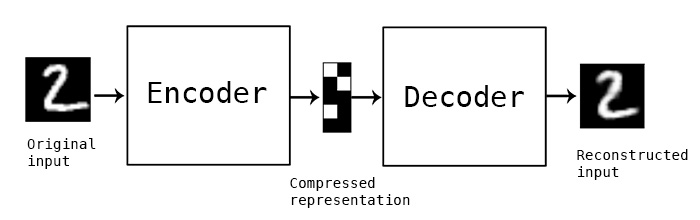

En ella podemos observar como consta de dos bloques: el encoder y el decoder.

Por una parte, el **encoder** toma los datos de entrada y los comprime en una representación mucho más compacta.

Por la otra, el **decoder** coge esa representación (o codificación) comprimida y trata de reconstruir los datos originales con el menor error posible.

A lo largo de esta práctica haremos lo siguiente:

* Empezaremos con un AutoEncoder muy simple, en el que tanto el encoder como el decoder tendrán una sola capa Densa.
* Complicaremos un poco más la arquitectura añadiendo más capas
* Cambiaremos la arquitectura para hacer uso de capas convolucionales
* Usaremos el AE convolucional para reducir el ruido presente en nuestras imágenes


**¡Comenzemos!**

Vamos a construir el AutoEncoder más simple posible:

In [4]:
import keras
from keras import layers

# This is the size of our encoded representations (dimmensions of the BOTTLENECK)
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

Usamos una función de activación ReLu para codificar la información de la entrada, puesto que esta no limita, mientras que si lo hiciéramos con la Sigmoide estaríamos limitando al intervalo [0-1].

Además se entrena más rápido (mejora la convergencia)

In [5]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_6 (Dense)             (None, 32)                25120     
                                                                 
 dense_7 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50992 (199.19 KB)
Trainable params: 50992 (199.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [7]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))

# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [8]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [9]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [11]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 7s 5ms/step - loss: 0.2781 - val_loss: 0.1882
Epoch 2/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1703 - val_loss: 0.1533
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1440 - val_loss: 0.1333
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1285 - val_loss: 0.1212
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1185 - val_loss: 0.1131
Epoch 6/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1116 - val_loss: 0.1073
Epoch 7/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1067 - val_loss: 0.1033
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1029 - val_loss: 0.1000
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1000 - val_loss: 0.0974
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0979 - val_loss: 0.0958

In [12]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 2s 5ms/step


In [13]:
encoded_imgs.shape

(10000, 32)

Ahora vamos a mostrar la imagen y el código latente correspondiente:

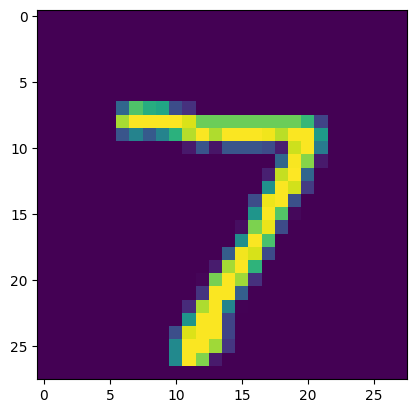

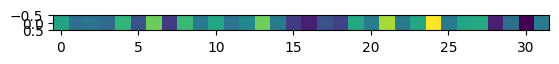

(<matplotlib.image.AxesImage at 0x7e33385e7d30>, None)

In [18]:
import matplotlib.pyplot as plt
plt.imshow(x_test[0].reshape(28, 28)), plt.show()
print("\n")
plt.imshow(encoded_imgs[0, :].reshape(1,encoded_imgs[0, :].shape[0])), plt.show()

Y ahora la imagen reconstruída a partir de ese código latente:

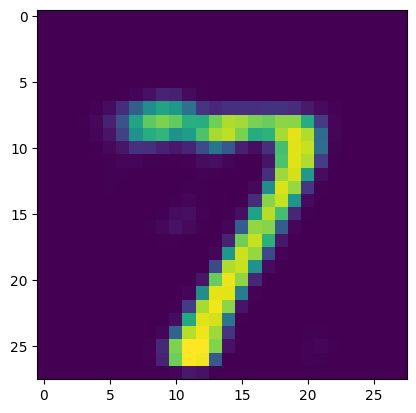

(<matplotlib.image.AxesImage at 0x7e3338438b80>, None)

In [19]:
plt.imshow(decoded_imgs[0].reshape(28, 28)), plt.show()

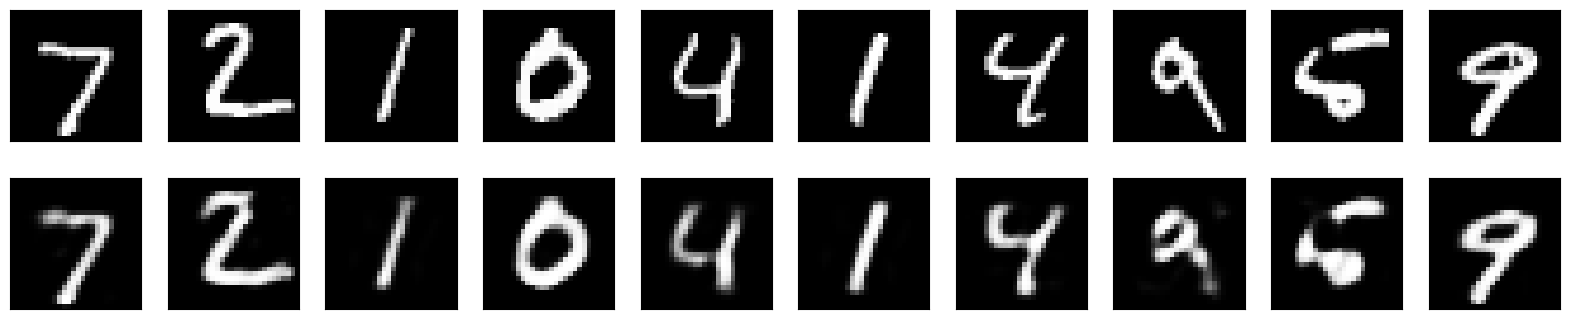

In [20]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

¡Fijaos lo fácil que ha sido, ya tenemos nuestro primer autoencoder funcionando!

Además, tal y como vimos en el video de Geoffrey Hinton "[From PCA to autoencoders](https://www.youtube.com/watch?v=PSOt7u8u23w)", lo que está ocurriendo es que el autoencoder está calculando una representación comprimida de los datos (lo que obtenemos a la salida del encoder) que no es otra cosa que una aproximación a lo que obtendríamos si aplicásemos una PCA. Si no sabéis de lo que estamos hablando, os recomiendo que veáis el video anterior.

Vamos a complicar un poco el asunto. Vamos a convertir nuestro autoencoder en un **deep** autoencoder. ¿Cómo? Añadiendo más capas al encoder y al decoder.

Mirad:

In [21]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

In [22]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 4s 6ms/step - loss: 0.2440 - val_loss: 0.1659
Epoch 2/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1502 - val_loss: 0.1366
Epoch 3/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1310 - val_loss: 0.1234
Epoch 4/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1213 - val_loss: 0.1169
Epoch 5/100
235/235 [==============================] - 2s 7ms/step - loss: 0.1156 - val_loss: 0.1115
Epoch 6/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1111 - val_loss: 0.1075
Epoch 7/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1075 - val_loss: 0.1047
Epoch 8/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1049 - val_loss: 0.1026
Epoch 9/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1027 - val_loss: 0.1010
Epoch 10/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1010 - val_lo

313/313 [==============================] - 0s 1ms/step


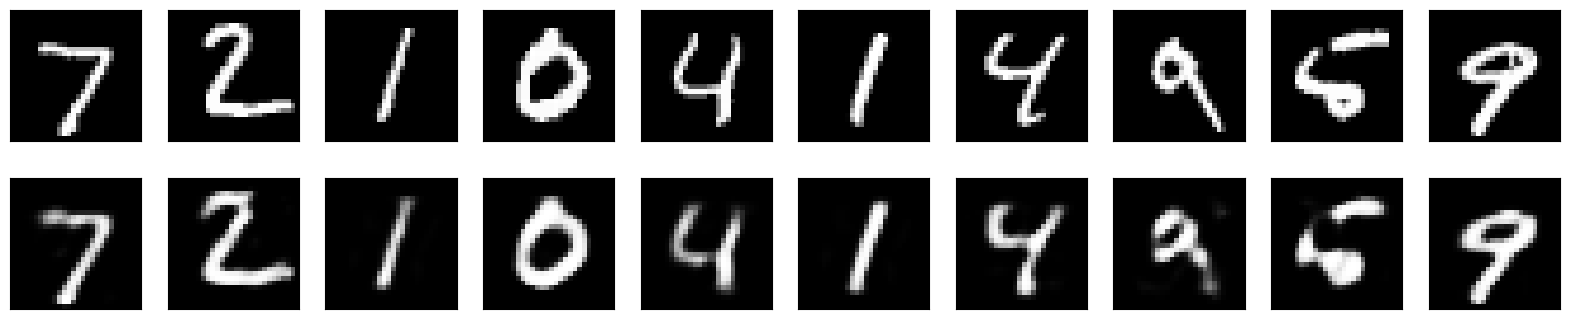

In [23]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Fijaos en cómo las pérdidas que obtenemos ahora son un poco mejores: de ~0.09 que obteníamos antes en validación, a ~0.08.

Ha llegado el momento de ponernos serios. Estamos tratando con imágenes, ¿verdad?

¿Cómo podríamos mejorar el comportamiento de nuestro autoencoder entonces?

¡Eso es! ¡Con capas **convolucionales**!

Vamos a comprobarlo:

In [24]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

- El primer argumento de Conv2D es el número de filtros de esa capa (en otras palabras, el número de dimensiones de la "imagen" de salida)
- El max pooling divide entre 2 cada dimensión (2,2)

Como vamos a trabajar con imágenes, tenemos que redimensionar los datos para que tengan 2 dimensiones: de 786 a (28, 28, 1), porque son imágenes en escala de grises.

Además, normalizaremos las imágenes entre 0 y 1: dividiremos entre 255, ya que las imágenes están codificadas con 8 bits sin signo (uint8).

In [25]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

Tras esto, entrenamos nuestro DC (Deep Convolutional) AutoEncoder:

*(Atención: ahora es importante tener seleccionada GPU o TPU, de lo contrario el entrenaiento será muy lento)*

In [26]:
logs = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
469/469 [==============================] - 11s 7ms/step - loss: 0.2095 - val_loss: 0.1385
Epoch 2/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1289 - val_loss: 0.1203
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1178 - val_loss: 0.1136
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1124 - val_loss: 0.1091
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1087 - val_loss: 0.1063
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1061 - val_loss: 0.1036
Epoch 7/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1041 - val_loss: 0.1024
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1024 - val_loss: 0.1004
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1011 - val_loss: 0.0994
Epoch 10/50
469/469 [==============================] - 4s 7ms/step - loss: 0.1000 - val_loss: 0.098

También podemos visualizar las curvas de entrenamiento, que se guardan en la variable history:

In [27]:
logs.history.keys()

dict_keys(['loss', 'val_loss'])

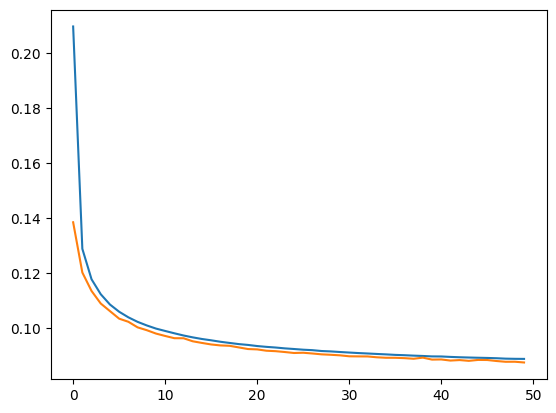

In [28]:
import matplotlib.pyplot as plt

plt.plot(logs.history['loss'])
plt.plot(logs.history['val_loss'])

313/313 [==============================] - 1s 3ms/step


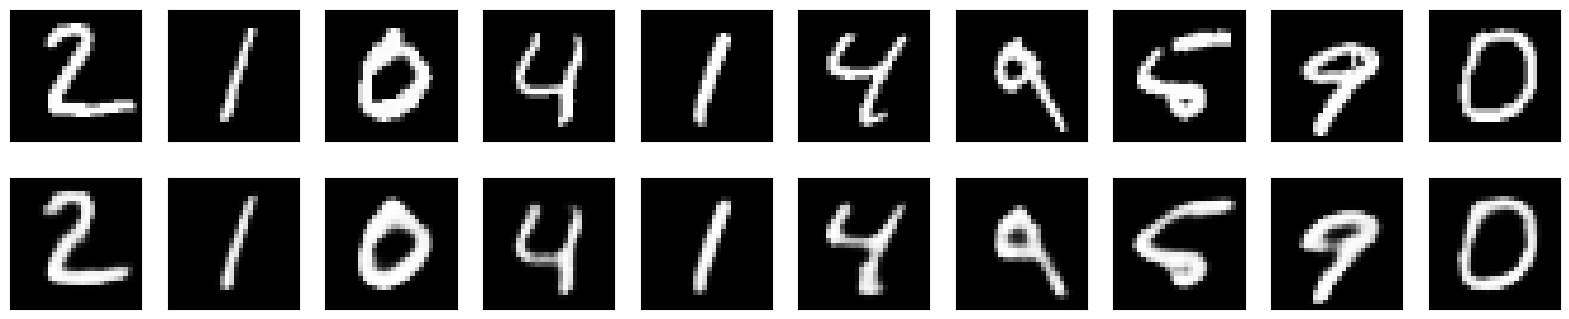

In [29]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Además, podemos también mirar las representaciones obtenidas por el encoder, las cuales tienen unas dimensiones de 4x4x8 (no 8x8x4).

Para poder visualizarlas en 2D, las redimensionaremos a 4x32.

313/313 [==============================] - 1s 2ms/step


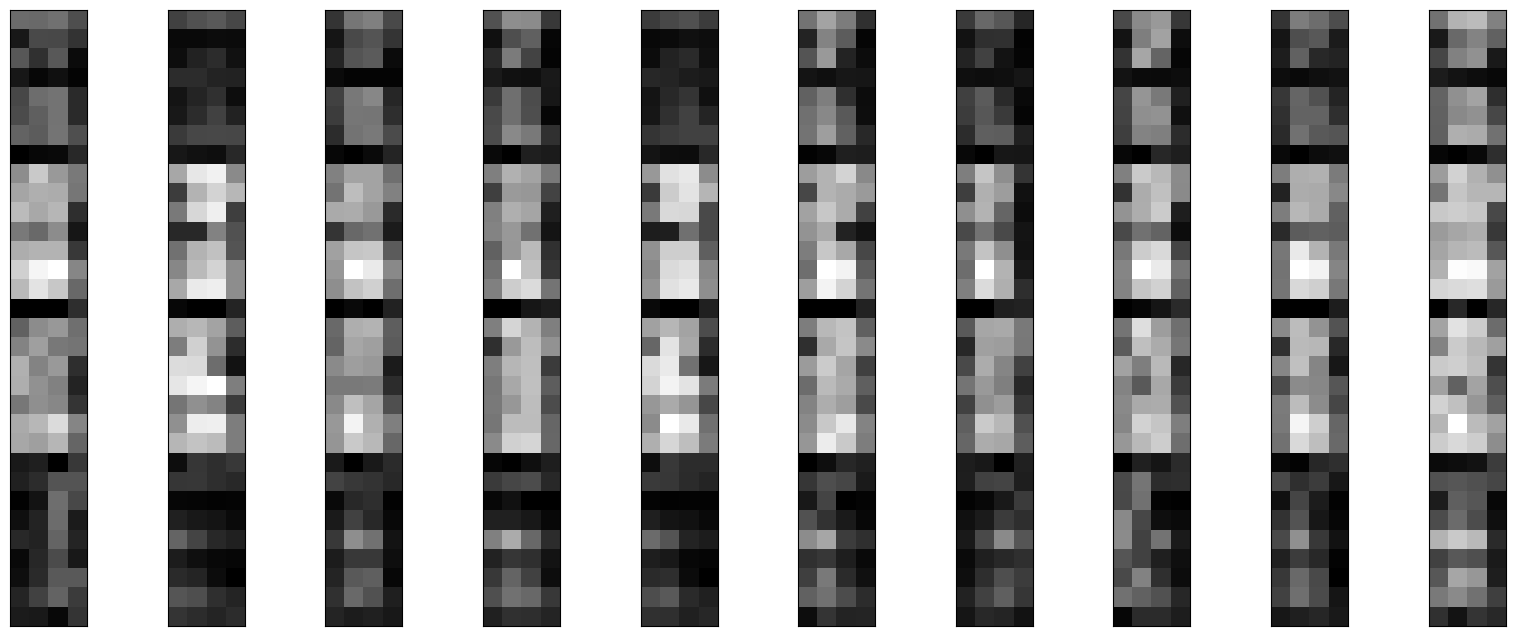

In [30]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((4, 4 * 8)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

En teoría, en estas representaciones se encuentra la información necesaria para reconstruir los datos originales con el menor error posible.

Pero basta de cháchara, vamos a ver un ejemplo de aplicación real de AutoEncoders: **reducción de ruido en imágenes**.

Para ello, vamos a generar ruido sintético en nuestras imágenes y a tratar de eliminarlo con nuestro modelo.

In [32]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# add noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Veamos qué es lo que hemos hecho:

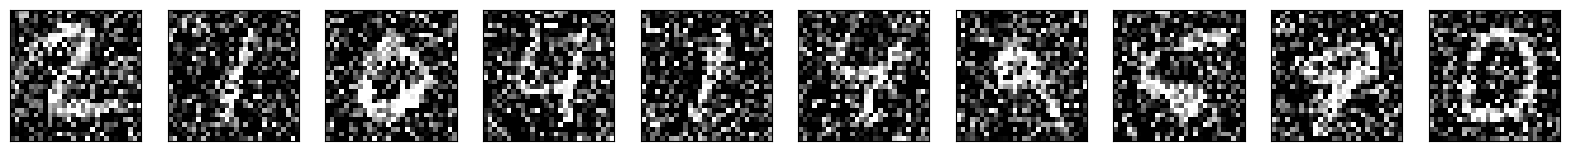

In [33]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

En efecto, hemos añadido una cantidad de ruido considerable. Vamos a intentar eliminarlo con un autoencoder convolucional:

In [34]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32) -> 1568-dimensional

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

logs = autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/100
469/469 [==============================] - 7s 9ms/step - loss: 0.1597 - val_loss: 0.1170
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1139 - val_loss: 0.1099
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1084 - val_loss: 0.1056
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1054 - val_loss: 0.1032
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1035 - val_loss: 0.1022
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1020 - val_loss: 0.1011
Epoch 7/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1009 - val_loss: 0.0998
Epoch 8/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0999 - val_loss: 0.0988
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0993 - val_loss: 0.0981
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0986 - val_lo

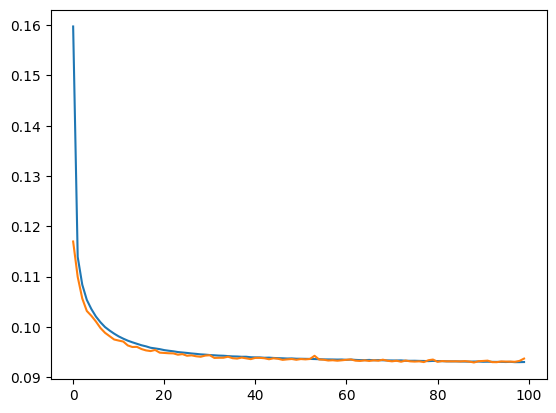

In [35]:
plt.plot(logs.history['loss'])
plt.plot(logs.history['val_loss'])

Visualicemos ahora los resultados, a ver qué hemos conseguido:

313/313 [==============================] - 1s 2ms/step


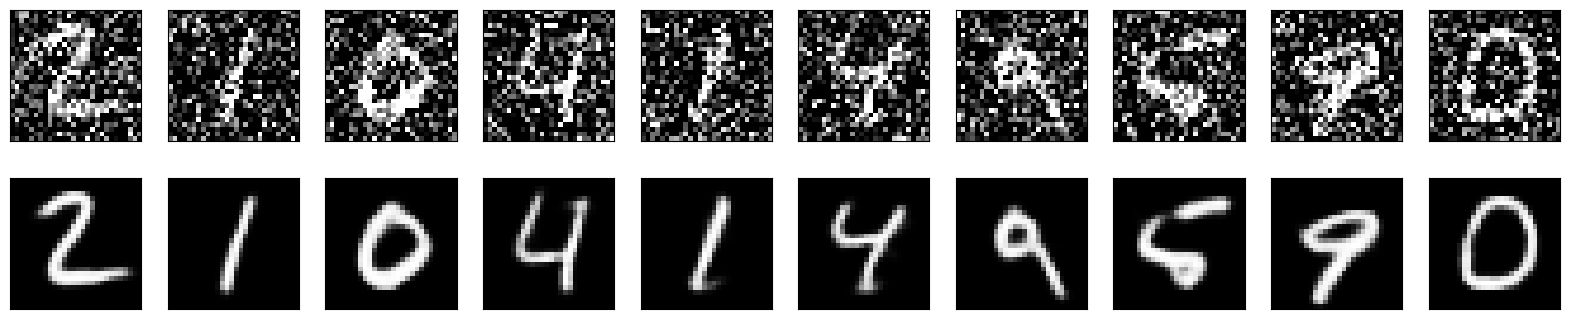

In [36]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


¿Qué os parece? Nada mal, ¿no? ¡Hemos conseguido eliminar totalmente el ruido!